# Data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
IMAGE_SIZE = [100, 100]
epochs = 2
batch_size = 64

train_path = 'D:/assets/data/Fruits-360/fruits-360/Training'
valid_path = 'D:/assets/data/Fruits-360/fruits-360/Validation'

In [3]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

print("Number of training images:", len(image_files))
print("Number of validation images: ", len(valid_image_files))
print("Number of classes: ", len(folders))

Number of training images: 67692
Number of validation images:  22688
Number of classes:  131


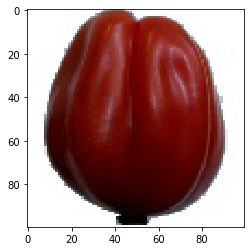

In [4]:
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

# Model

We make use of transfer learning to load the feature transformation layers of ResNet50 model and then cut off it's head so we can add our own logistic regession output layer(for classifying between the number of classes we want).

ResNet50(50 layers) model is a novel architecture which contains two different branches - main branch and side branch. The main branch is same as other vanilla CNN architectures but the side branch basically connects output directly to the input. So main branch returns us some value f(x) and through side branch we get x where x is the input. Therefore our output becomes f(x) + x. This is done so the deeper our neural network becomes it won't harm the performance but only improve it since the residual layers can just learn the identity function i.e.f(x)=x if we add this side branch.

In [5]:
# Loading the model feature transformation layers and then adding the final linear layer using keras

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# we specify image size, weights and then we choose not to include top and hence cutting off the head of the model(output logistic regression layer)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

# our layers(for specific output classes) - you can add more if you want
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [6]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

model.summary()

[0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 7, 7, 256)    1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 7, 7, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 7, 7, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 7, 7, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 7, 7, 256)    0           conv4_block1_2_bn[0][0]      

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

# Data Generators

In [8]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [9]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 22688 images belonging to 131 classes.
{&#39;Apple Braeburn&#39;: 0, &#39;Apple Crimson Snow&#39;: 1, &#39;Apple Golden 1&#39;: 2, &#39;Apple Golden 2&#39;: 3, &#39;Apple Golden 3&#39;: 4, &#39;Apple Granny Smith&#39;: 5, &#39;Apple Pink Lady&#39;: 6, &#39;Apple Red 1&#39;: 7, &#39;Apple Red 2&#39;: 8, &#39;Apple Red 3&#39;: 9, &#39;Apple Red Delicious&#39;: 10, &#39;Apple Red Yellow 1&#39;: 11, &#39;Apple Red Yellow 2&#39;: 12, &#39;Apricot&#39;: 13, &#39;Avocado&#39;: 14, &#39;Avocado ripe&#39;: 15, &#39;Banana&#39;: 16, &#39;Banana Lady Finger&#39;: 17, &#39;Banana Red&#39;: 18, &#39;Beetroot&#39;: 19, &#39;Blueberry&#39;: 20, &#39;Cactus fruit&#39;: 21, &#39;Cantaloupe 1&#39;: 22, &#39;Cantaloupe 2&#39;: 23, &#39;Carambula&#39;: 24, &#39;Cauliflower&#39;: 25, &#39;Cherry 1&#39;: 26, &#39;Cherry 2&#39;: 27, &#39;Cherry Rainier&#39;: 28, &#39;Cherry Wax Black&#39;: 29, &#39;Cherry Wax Red&#39;: 30, &#39;Cherry Wax Yellow&#39;: 31, &#39;Chestnut&#39;: 32, &#39;Clementine&#39;: 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
min: -66.779 max: 151.061


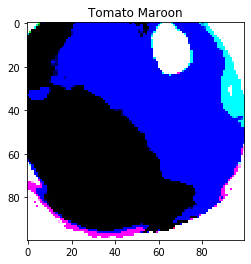

In [10]:
# should be a strangely colored image (due to ResNet weights being BGR) - confirms that preprocessing worked
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [11]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Training

In [12]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
1057/1057 [==============================] - 2981s 3s/step - loss: 1.1465 - accuracy: 0.9073 - val_loss: 1.2137 - val_accuracy: 0.9203
Epoch 2/2
1057/1057 [==============================] - 2397s 2s/step - loss: 0.1853 - accuracy: 0.9819 - val_loss: 0.8567 - val_accuracy: 0.9468


# Confusion Matrix and Plots

There is one row and column for every class in the confusion matrix. Guide on how to read a confusion matrix - https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826#:~:text=A%20confusion%20matrix%20is%20a,the%20classes%20correctly%20or%20incorrectly

In [13]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [14]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 67692
Found 67692 images belonging to 131 classes.
50
100
150
200
250
300
350
400
450
500
[[479   0   0 ...   0   0   0]
 [  3 408   0 ...   0   0   0]
 [  0   0 480 ...   0   0   0]
 ...
 [  0   0   0 ... 474   0   0]
 [  0   0   0 ...   0 735   0]
 [  0   0   0 ...   0   0 475]]


In [15]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 22688
Found 22688 images belonging to 131 classes.
50
100
150
[[149   0   0 ...   0   0   0]
 [  4 108   0 ...   0   0   0]
 [  0   0 159 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]


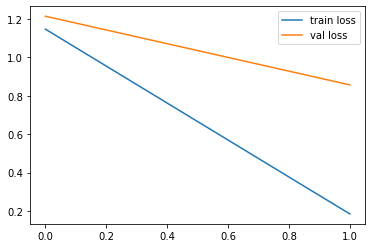

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

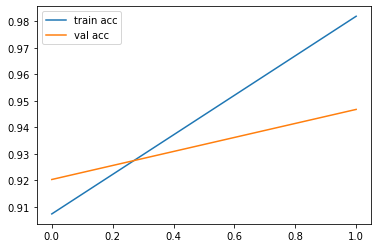

In [17]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()